# Team Assignment 4
Authors: Data Ninjas - Jesse Warren & Haochen Li<br>
Date: 9/19/2024 <br>
Original Dataset: <a href="https://github.com/Welltory/hrv-covid19/tree/master"> Source GitHub</a>

### 0. Relavent information for running this notebook:
    1. Install requirements:
        pandas==2.0.3
        numpy==1.26.4
        matplotlib==3.7.1
        seaborn==0.12.2
        scikit-learn==1.2.2
    2. Run each cell of the notebook
    3. Check out our interpretations of results and discussions!

### 1. Data Context & Sampling

### 1.1 Data context

- <a href="https://github.com/Welltory/hrv-covid19/tree/master"> Data Source</a> (copied from original source README file):
    1. "Heart rate variability measurements. Measurements were made with any Bluetooth-enabled heart rate monitor or with a smartphone camera with a high resolution - a method called Photoplethysmography (PPG). It is a simple optical technique used to detect blood volume changes in the microvascular bed of tissue to track the heartbeat."
    2. "Data from user-connected gadgets including devices such as Apple Watch and Garmin that sync with Google Fit or Apple Health."
    3. "Clinically validated physical and mental health assessments."
- Known Biases/Limitations: 
    1. Potentially noisy data from devices (eg.bluetooth collection);
    2. Small participant dataset, so variation could be huge;
    4. For some features, data are missing, which is a limitation.
- Problem statement
    - We are trying to predict patient overall state using their blood pressure, heart rate, hrv, height and weight or other variables.
    - The dataset provides such data.

### 1.2 Data Sampling

In [34]:
import pandas as pd
import numpy as np
# data visualization libs
import matplotlib.pyplot as plt
import seaborn as sns
# dimensionality reduction libs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [35]:
# read data

df_bp = pd.read_csv("https://raw.githubusercontent.com/Welltory/hrv-covid19/master/data/blood_pressure.csv") # blood pressure
df_hr = pd.read_csv("https://raw.githubusercontent.com/Welltory/hrv-covid19/master/data/heart_rate.csv") # heart rate
df_hrv = pd.read_csv("https://raw.githubusercontent.com/Welltory/hrv-covid19/master/data/hrv_measurements.csv") # hrv
df_p = pd.read_csv("https://raw.githubusercontent.com/Welltory/hrv-covid19/master/data/participants.csv")# participants

sampled_df_bp = df_bp.sample(n=30, random_state = 0) # random_state = 0 to generate repetitive result
sampled_df_hr = df_hr.sample(n=30, random_state = 0)
sampled_df_hrv = df_hrv.sample(n=30, random_state = 0)
sampled_df_p = df_p.sample(n=30, random_state = 0)

print("Data sampling:")
print(sampled_df_bp)
print("---"*10)
print(sampled_df_hr)
print("---"*10)
print(sampled_df_hrv)
print("---"*10)
print(sampled_df_p)

Data sampling:
      user_code  measurement_datetime  diastolic  systolic  \
503  a1c2e6b2eb  2020-05-22  21:15:04         72       112   
646  fde84801d8  2020-05-02  14:57:46         79       110   
245  a1c2e6b2eb  2020-03-07  12:02:53         88       126   
142  6be5033971  2020-04-26  07:00:56         70       127   
493  a1c2e6b2eb  2020-05-20  00:19:46         78       120   
358  a1c2e6b2eb  2020-04-26  21:44:33         79       122   
622  fde84801d8  2020-04-28  11:30:39         83       114   
40   1ce1d77659  2020-05-12  14:21:59         75       121   
369  a1c2e6b2eb  2020-04-30  08:43:45         81       112   
85   6be5033971  2020-01-24  16:41:00         77       126   
175  6be5033971  2020-05-15  00:03:17         73       112   
517  a1c2e6b2eb  2020-05-29  21:31:55         80       122   
352  a1c2e6b2eb  2020-04-26  01:28:36         81       116   
452  a1c2e6b2eb  2020-05-13  09:36:50         88       112   
694  fde84801d8  2020-05-16  19:03:31         88       

In [36]:
# country imbalance check
country_counts = df_p['country'].value_counts()
print(country_counts)

country
Russia            66
United States     60
United Kingdom    12
Ukraine            7
Brazil             6
Belarus            5
France             3
Indonesia          2
Finland            2
Spain              1
Sweden             1
Canada             1
Isle of Man        1
Afghanistan        1
Switzerland        1
Australia          1
Myanmar            1
Iraq               1
Hungary            1
Netherlands        1
Germany            1
Norway             1
Uzbekistan         1
Qatar              1
Tanzania           1
Name: count, dtype: int64


### Data sampling result:
We used random sampling (with random state = 0 to generate repetitive result) and sampled 30 data points from each interested dataset. Comments are as follow:
1. Data contains participant from mostly Russia and the US, which is imbalanced and not representative enough for the whole pupulation. (see country imbalance check)
2. In order to build a model to predict the severeness using blood pressure, heart rate, hrv, weight and height, there is a need to split the data into train and test sets.


## 2. Data structure, descriptive statistics, data quality, and variable relationships

### 2.1 Data Structure and Descriptive Statistics

In [37]:
# for blood pressure
print("Data dimension:", df_bp.shape)
print(df_bp.info())
print(df_bp.describe())

Data dimension: (721, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_code                 721 non-null    object 
 1   measurement_datetime      721 non-null    object 
 2   diastolic                 721 non-null    int64  
 3   systolic                  721 non-null    int64  
 4   functional_changes_index  299 non-null    float64
 5   circulatory_efficiency    299 non-null    float64
 6   kerdo_vegetation_index    283 non-null    float64
 7   robinson_index            299 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 45.2+ KB
None
        diastolic    systolic  functional_changes_index  \
count  721.000000  721.000000                299.000000   
mean    81.228849  119.441054                  2.594013   
std      8.865761   10.522578                  0.291302   
min     25.000000

### Blood Pressure missing value comment: 
- functional_changes_index, circulatory_efficiency, kerdo_vegetation_index and robinson_index features have missing values.

In [38]:
# for heart rate
print("Data dimension:", df_hr.shape)
print(df_hr.info())
print(df_hr.describe())

Data dimension: (523783, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523783 entries, 0 to 523782
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_code   523783 non-null  object
 1   datetime    523783 non-null  object
 2   heart_rate  523783 non-null  int64 
 3   is_resting  523783 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 16.0+ MB
None
          heart_rate     is_resting
count  523783.000000  523783.000000
mean       90.856626       0.005546
std        25.054152       0.074266
min        10.000000       0.000000
25%        71.000000       0.000000
50%        87.000000       0.000000
75%       108.000000       0.000000
max       232.000000       1.000000


Heart rate missing value comment: no missing value feature.

In [39]:
# HRV
print("Data dimension:", df_hrv.shape)
print(df_hrv.info())
print(df_hrv.describe())

Data dimension: (3245, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_code             3245 non-null   object 
 1   rr_code               3245 non-null   object 
 2   measurement_datetime  3245 non-null   object 
 3   time_of_day           3245 non-null   object 
 4   bpm                   3245 non-null   int64  
 5   meanrr                3245 non-null   float64
 6   mxdmn                 3245 non-null   float64
 7   sdnn                  3245 non-null   float64
 8   rmssd                 3245 non-null   float64
 9   pnn50                 3245 non-null   float64
 10  mode                  3245 non-null   float64
 11  amo                   3245 non-null   float64
 12  lf                    3245 non-null   float64
 13  hf                    3245 non-null   float64
 14  vlf                   3245 non-null   float64

### HRV missing value comment: 
- how_sleep and tags have missing values.

In [40]:
# Participants
print("Data dimension:", df_p.shape)
print(df_p.info())
print(df_p.describe())

Data dimension: (185, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_code       185 non-null    object 
 1   gender          185 non-null    object 
 2   age_range       185 non-null    object 
 3   city            173 non-null    object 
 4   country         179 non-null    object 
 5   height          183 non-null    float64
 6   weight          185 non-null    float64
 7   symptoms_onset  147 non-null    object 
dtypes: float64(2), object(6)
memory usage: 11.7+ KB
None
           height      weight
count  183.000000  185.000000
mean   169.976393   77.927757
std     12.400103   19.552541
min    132.080000   43.500000
25%    163.500000   63.500000
50%    168.000000   74.344000
75%    174.500000   90.537000
max    250.000000  154.221000


### Participants missing value comments: 
- city, country, height and symptoms_onset has missing value. Since height is the the variable in focus but only 2 data missing, we may consider drop these 2 data points.

### Data structure Interpretation
- blood pressure subset has 721 rows and 8 columns
- heart rate subset has 523783 rows and 4 columns
- hrv subset has 3245 rows and 22 columns
- participants subset has 185 rows and 8 columns

### Descriptive Statistics
All deviation larger than 10% of mean will be considered as high, vice versa. 
- blood pressure subset: diastolic has high standard deviation and systolic has small standard deviation.
- heart rate subset: heart rate has large standard deviation.
- hrv subset: all numerical variables have large standard deviation.
- participants: weight have higher standard deviation, while height has relatively low standard deviation.


### 2.2 Data Quality

In [41]:
# missing value summary
missing_values_bp = df_bp.isnull().sum()
missing_values_hr = df_hr.isnull().sum()
missing_values_hrv = df_hrv.isnull().sum()
missing_values_p = df_p.isnull().sum()
print("Blood Pressure Missing values per column:\n", missing_values_bp)
print("Heart Rate Missing values per column:\n", missing_values_hr)
print("HRV Missing values per column:\n", missing_values_hrv)
print("Participants Missing values per column:\n", missing_values_p)

# duplicate rows
duplicate_rows_bp = df_bp[df_bp.duplicated()].shape[0]
duplicate_rows_hr = df_hr[df_hr.duplicated()].shape[0]
duplicate_rows_hrv = df_hrv[df_hrv.duplicated()].shape[0]
duplicate_rows_p = df_p[df_p.duplicated()].shape[0]
print("Blood Pressure Duplicate rows: ", duplicate_rows_bp)
print("Heart Rate Duplicate rows: ", duplicate_rows_hr)
print("HRV Missing Duplicate rows: ", duplicate_rows_hrv)
print("Participants Duplicate rows: ", duplicate_rows_p)

Blood Pressure Missing values per column:
 user_code                     0
measurement_datetime          0
diastolic                     0
systolic                      0
functional_changes_index    422
circulatory_efficiency      422
kerdo_vegetation_index      438
robinson_index              422
dtype: int64
Heart Rate Missing values per column:
 user_code     0
datetime      0
heart_rate    0
is_resting    0
dtype: int64
HRV Missing values per column:
 user_code                  0
rr_code                    0
measurement_datetime       0
time_of_day                0
bpm                        0
meanrr                     0
mxdmn                      0
sdnn                       0
rmssd                      0
pnn50                      0
mode                       0
amo                        0
lf                         0
hf                         0
vlf                        0
lfhf                       0
total_power                0
how_feel                   0
how_mood          

### Data Quality Interpretation:
1. Four missing value features for blood pressure; no missing values for hrv; four missing value features for participants(only 1 interested feature, but only 2 rows missing the value). Overall, it contains some missing value features but hardly affect the core features we are interested in.
2. No duplicate! Which is good since we don't need to clean those duplicated data.

## 3. Data Visualization

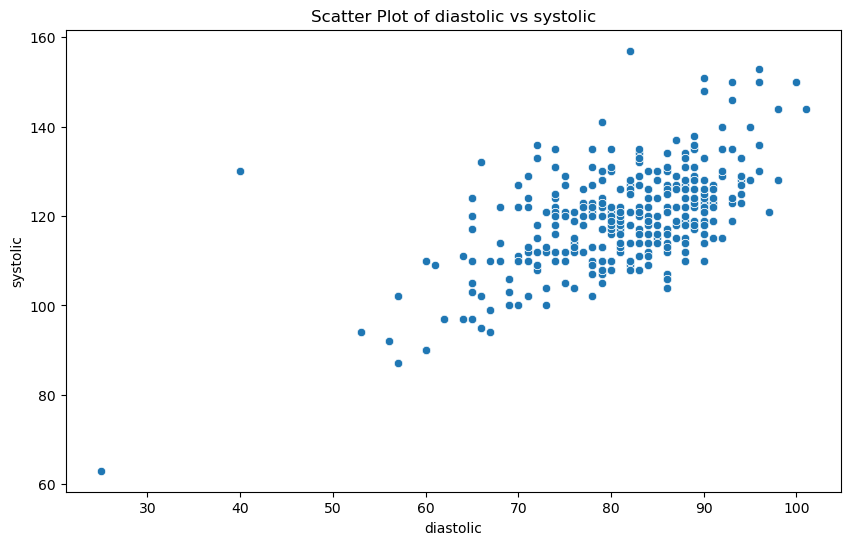

In [42]:
# bp Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='diastolic', y='systolic', data=df_bp)  
plt.title('Scatter Plot of diastolic vs systolic')
plt.xlabel('diastolic')
plt.ylabel('systolic')
plt.show()

c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


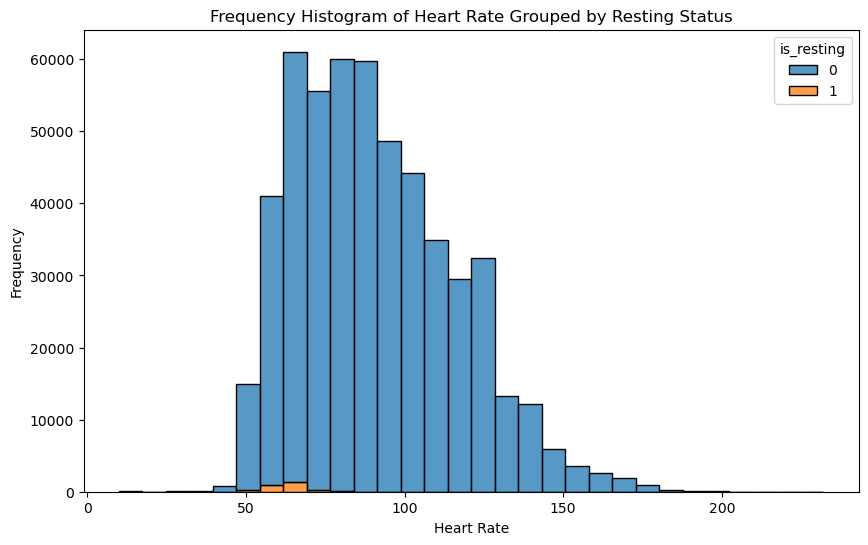

In [43]:
# hr heart rate histogram by heart_rate and group by is_resting
plt.figure(figsize=(10, 6))
sns.histplot(data=df_hr, x='heart_rate', hue='is_resting', multiple='stack', bins=30)
plt.title('Frequency Histogram of Heart Rate Grouped by Resting Status')
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')
plt.show()

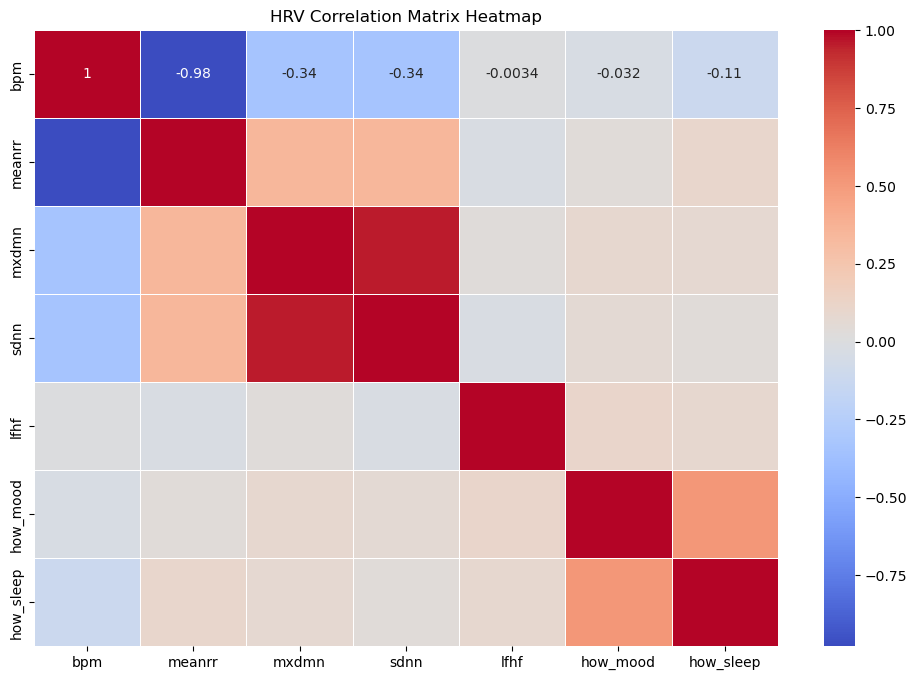

In [44]:
# hrv corr matrix heat map
plt.figure(figsize=(12, 8))
correlation_matrix = df_hrv[['bpm','meanrr','mxdmn','sdnn','lfhf','how_mood','how_sleep']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('HRV Correlation Matrix Heatmap')
plt.show()

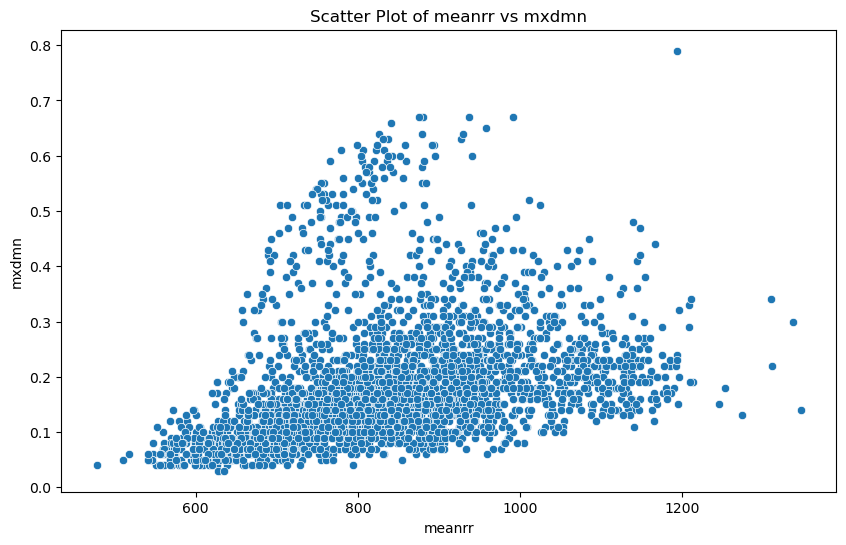

In [45]:
# hrv: Scatter Plot of meanrr vs mxdmn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='meanrr', y='mxdmn', data=df_hrv) 
plt.title('Scatter Plot of meanrr vs mxdmn')
plt.xlabel('meanrr')
plt.ylabel('mxdmn')
plt.show()

c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


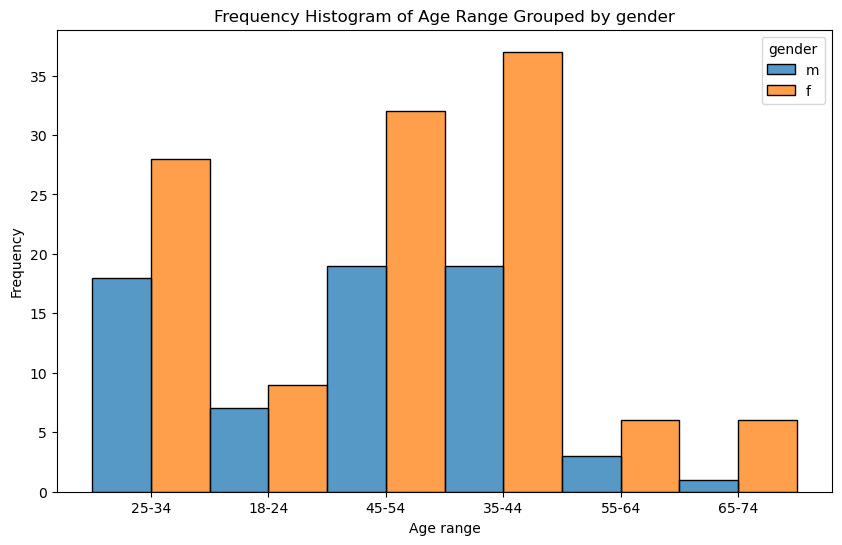

In [46]:
# p: age group investigation
plt.figure(figsize=(10, 6))
sns.histplot(data=df_p, x='age_range', hue='gender', multiple='dodge', bins=30)
plt.title('Frequency Histogram of Age Range Grouped by gender')
plt.xlabel('Age range')
plt.ylabel('Frequency')
plt.show()

c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


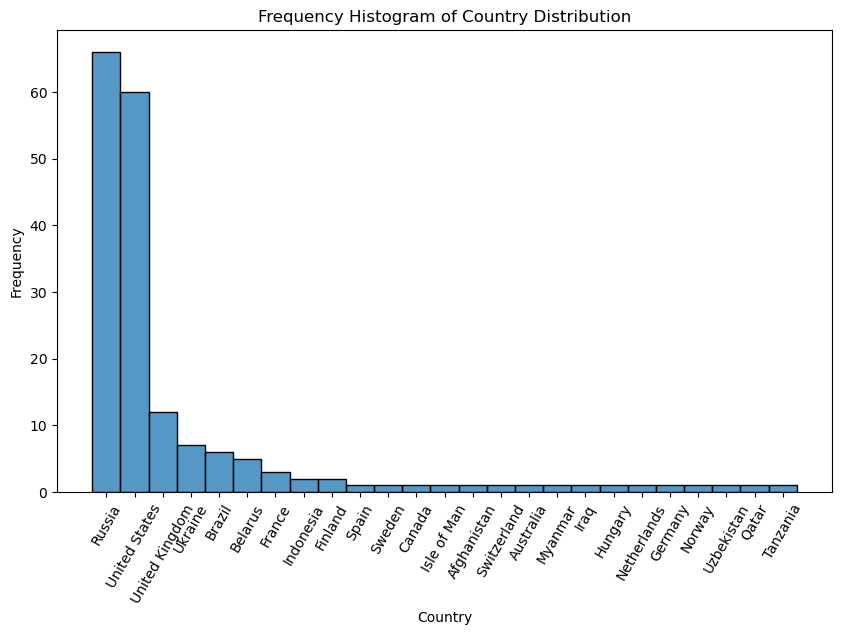

In [47]:
# P: country histogram (using help from github to do ordering)
df_p_copy = df_p.copy()
country_counts = df_p_copy['country'].value_counts() # count
sorted_countries = country_counts.index # sort

# Reorder the DataFrame based on the sorted countries
df_p_copy['country'] = pd.Categorical(df_p_copy['country'], categories=sorted_countries, ordered=True)

# Plot the histogram using the reordered DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(data=df_p_copy, x='country', bins=10)
plt.title('Frequency Histogram of Country Distribution')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=60) # rotate so that the country names would not overlap
plt.show()

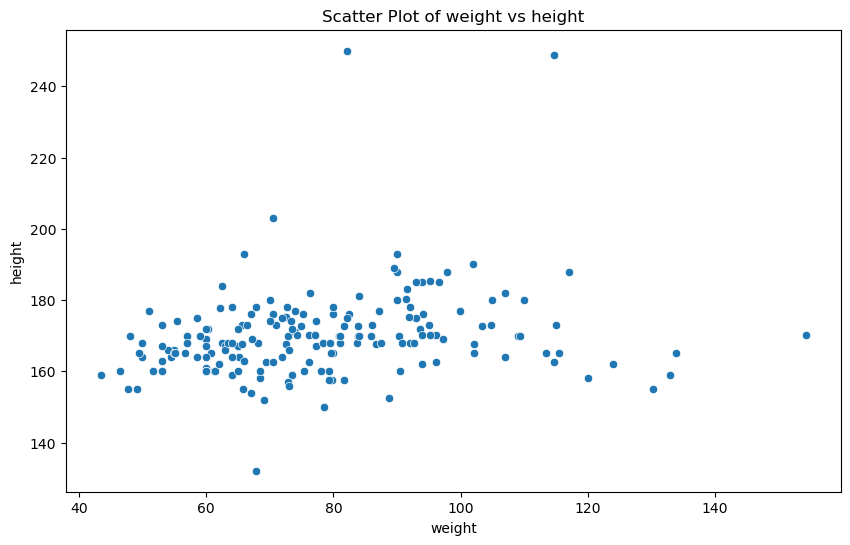

In [48]:
# p: weight and height scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weight', y='height', data=df_p) 
plt.title('Scatter Plot of weight vs height')
plt.xlabel('weight')
plt.ylabel('height')
plt.show()


c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


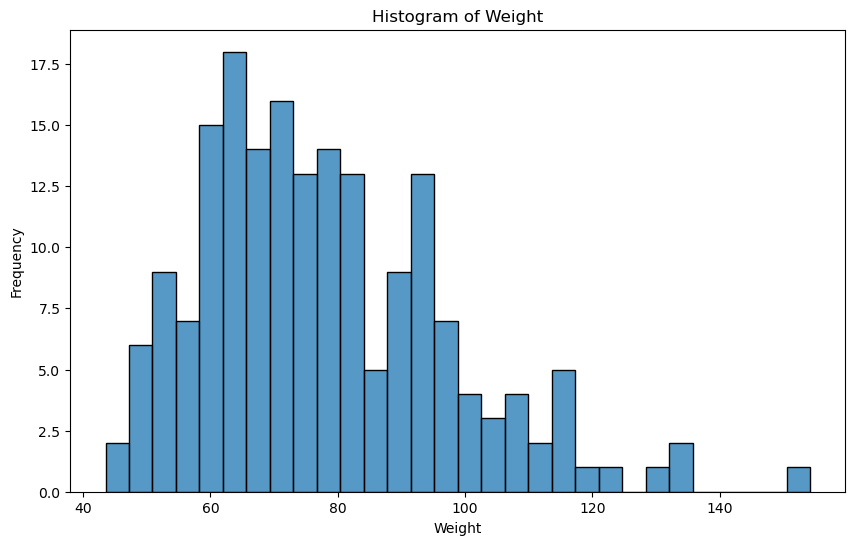

c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


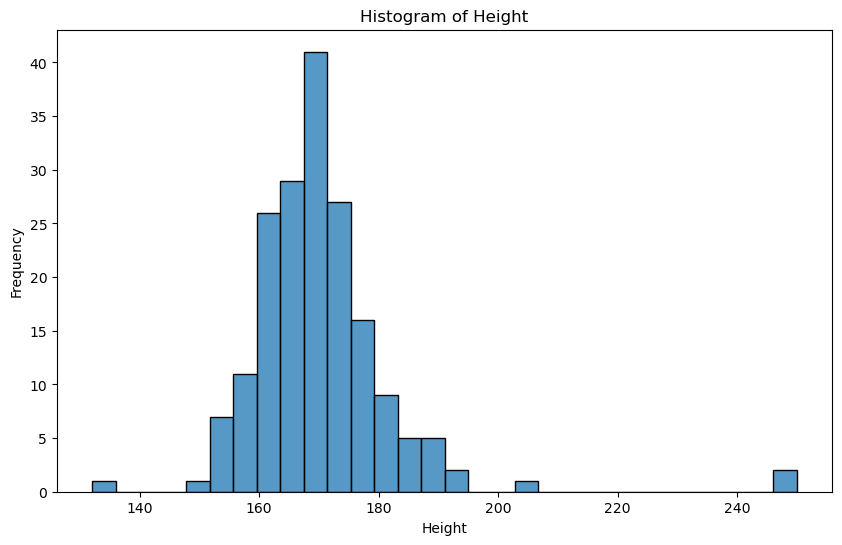

In [49]:
# Plot the histogram for weight
plt.figure(figsize=(10, 6))
sns.histplot(data=df_p, x='weight', bins=30)  
plt.title('Histogram of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

# Plot the histogram for height
plt.figure(figsize=(10, 6))
sns.histplot(data=df_p, x='height', bins=30) 
plt.title('Histogram of Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

## 4. Handling Missing Value, Duplicates and Outlier

### 4.1 Missing Value

From previous analysis:
1. Missing value features in blood pressure is not core and lots of data are missing. But we found those data are available for most days if we change the time scope from exact seconds to days;
2. Heart rate has no missing value column, no cleaning is needed;
3. HRV as no missing value column, no cleaning is needed;
4. Participants has 4 missing value features: city, country, height, symptoms_onset; since city, country and symptoms_onset are not core feature, we consider drop those features; and we just drop NAN rows for height. 

In [50]:
# blood pressure: transformation
df_bp['measurement_datetime'] = pd.to_datetime(df_bp['measurement_datetime'])
df_bp['measurement_date'] = df_bp['measurement_datetime'].dt.date
df_bp.drop('measurement_datetime', axis = 1, inplace=True)
df_bp.head()

,user_code,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index,measurement_date
0,01bad5a519,100,150,NaN,NaN,NaN,NaN,2020-04-29
1,01bad5a519,100,150,NaN,NaN,NaN,NaN,2020-04-30
2,01bad5a519,95,140,3.38,4545.0,6.0,141.4,2020-04-30
3,01bad5a519,95,140,NaN,NaN,NaN,NaN,2020-04-30
4,01bad5a519,80,130,2.89,4000.0,NaN,104.0,2020-05-01


In [51]:
# blood pressure: merge by user_code and measurement_date (with the help of copilot)
df_bp_grouped = df_bp.groupby(['user_code', 'measurement_date']).agg({
    'diastolic': 'mean',
    'systolic': 'mean',
    'functional_changes_index': 'max',
    'circulatory_efficiency': 'max',
    'kerdo_vegetation_index': 'max',
    'robinson_index': 'max'
}).reset_index()

print(df_bp_grouped.shape)
df_bp_grouped.head()

(249, 8)


,user_code,measurement_date,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index
0,01bad5a519,2020-04-29,100.000000,150.000000,NaN,NaN,NaN,NaN
1,01bad5a519,2020-04-30,96.666667,143.333333,3.38,4545.0,6.0,141.40
2,01bad5a519,2020-05-01,80.000000,126.000000,2.89,4000.0,-7.0,104.00
3,01bad5a519,2020-05-03,77.333333,114.666667,2.92,3800.0,16.0,114.00
4,01bad5a519,2020-05-04,85.600000,123.600000,2.93,2856.0,-6.0,104.55


In [52]:
# blood pressure: Drop NAN
df_bp_grouped.dropna(inplace=True)
df_bp = df_bp_grouped # update
print(df_bp.shape)
df_bp.head()


(160, 8)


,user_code,measurement_date,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index
1,01bad5a519,2020-04-30,96.666667,143.333333,3.38,4545.0,6.0,141.40
2,01bad5a519,2020-05-01,80.000000,126.000000,2.89,4000.0,-7.0,104.00
3,01bad5a519,2020-05-03,77.333333,114.666667,2.92,3800.0,16.0,114.00
4,01bad5a519,2020-05-04,85.600000,123.600000,2.93,2856.0,-6.0,104.55
5,01bad5a519,2020-05-06,89.333333,132.000000,3.26,4600.0,11.0,135.00


In [53]:
df_p.drop(['city','country','symptoms_onset'], axis=1, inplace=True)
df_p.dropna(inplace=True)
print(df_p.shape)
df_p.head()

(183, 5)


,user_code,gender,age_range,height,weight
0,007b8190cf,m,25-34,170.18,96.162
1,013f6d3e5b,f,18-24,174.00,77.300
2,01bad5a519,m,45-54,178.00,92.000
3,0210b20eea,f,25-34,169.00,60.000
4,024719e7da,f,45-54,158.00,68.500


### 4.2 Duplicates
Since we detected none duplicated rows in previous exploratory analysis, there is no need to clean duplicated data.

### 4.3 Outlier

Here we mainly delete outlier for heart_rate in heart rate df and height and weight in participants df. From previous analysis and visualization, the heart rate was NOT normally distributed (non-Gaussian) so we use the IQR method for removing the outliers, where we first calculate IQR with Q3-Q1 then decide the lower and upper boundary to be Q1 - k*IQR and Q3 + k*IQR. We pick k=1.5 here and then filter out datapoints outside the boundary.

In [54]:
# heart rate outlier

print("Before deleting outliers: ", df_hr.shape)

Q1 = df_hr['heart_rate'].quantile(0.25)
Q3 = df_hr['heart_rate'].quantile(0.75)
IQR = Q3 - Q1

# determine bounds with k=1.5
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers (with help from copilot)

df_hr = df_hr[(df_hr['heart_rate'] >= lower_bound) & (df_hr['heart_rate'] <= upper_bound)]
print("After deleting outliers: ", df_hr.shape)
df_hr.head()

Before deleting outliers:  (523783, 4)
After deleting outliers:  (519981, 4)


,user_code,datetime,heart_rate,is_resting
0,007b8190cf,2020-04-26 04:49:25,70,0
1,01bad5a519,2020-04-23 06:21:03,74,0
2,01bad5a519,2020-04-23 09:46:01,82,0
3,01bad5a519,2020-04-23 14:05:06,90,0
4,01bad5a519,2020-04-24 03:41:18,72,0


In [55]:
# do the similar to height and weights

print("Before deleting outliers: ", df_p.shape)

## for weight
Q1 = df_p['weight'].quantile(0.25)
Q3 = df_p['weight'].quantile(0.75)
IQR = Q3 - Q1

# determine bounds with k=1.5
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers (with help from copilot)
df_p = df_p[(df_p['weight'] >= lower_bound) & (df_p['weight'] <= upper_bound)]

## for height
Q1 = df_p['height'].quantile(0.25)
Q3 = df_p['height'].quantile(0.75)
IQR = Q3 - Q1

# determine bounds with k=1.5
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers (with help from copilot)
df_p = df_p[(df_p['height'] >= lower_bound) & (df_p['height'] <= upper_bound)]

print("After deleting outliers: ", df_p.shape)
df_p.head()

Before deleting outliers:  (183, 5)
After deleting outliers:  (174, 5)


,user_code,gender,age_range,height,weight
0,007b8190cf,m,25-34,170.18,96.162
1,013f6d3e5b,f,18-24,174.00,77.300
2,01bad5a519,m,45-54,178.00,92.000
3,0210b20eea,f,25-34,169.00,60.000
4,024719e7da,f,45-54,158.00,68.500


## 5. Data Transformation

c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


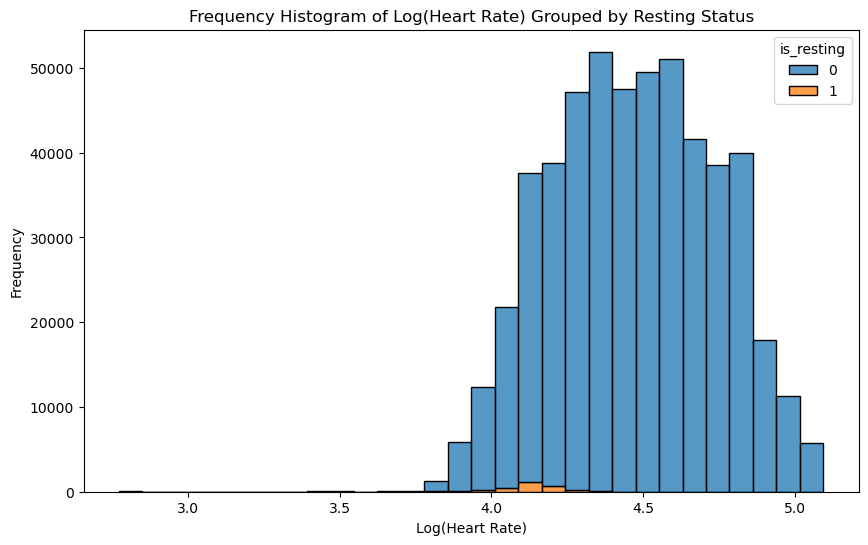

In [56]:
# In previous heart rate plot, heart rate histogram is right-skewed, so we use log transformation
# Create a new column for the logarithm of heart_rate
df_hr['log_heart_rate'] = np.log(df_hr['heart_rate'])

# Plot the frequency histogram of log(heart_rate) grouped by is_resting
plt.figure(figsize=(10, 6))
sns.histplot(data=df_hr, x='log_heart_rate', hue='is_resting', multiple='stack', bins=30)
plt.title('Frequency Histogram of Log(Heart Rate) Grouped by Resting Status')
plt.xlabel('Log(Heart Rate)')
plt.ylabel('Frequency')
plt.show()

c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


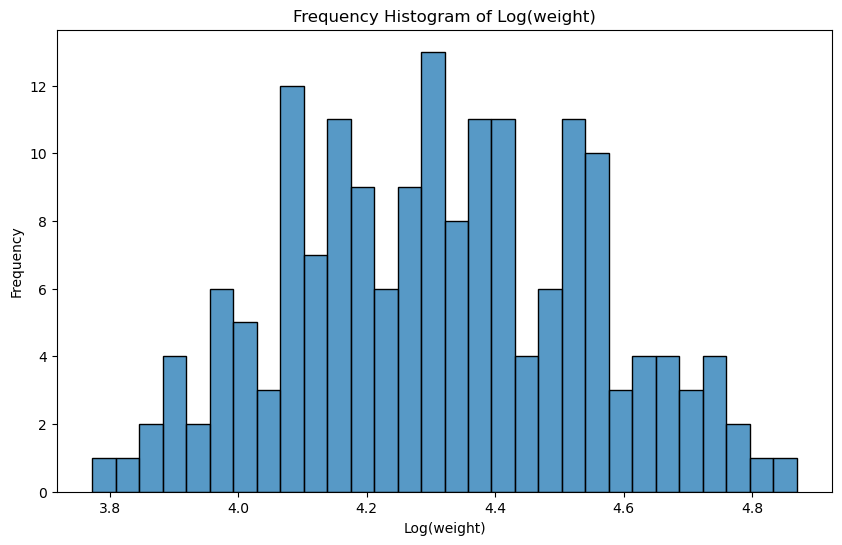

c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


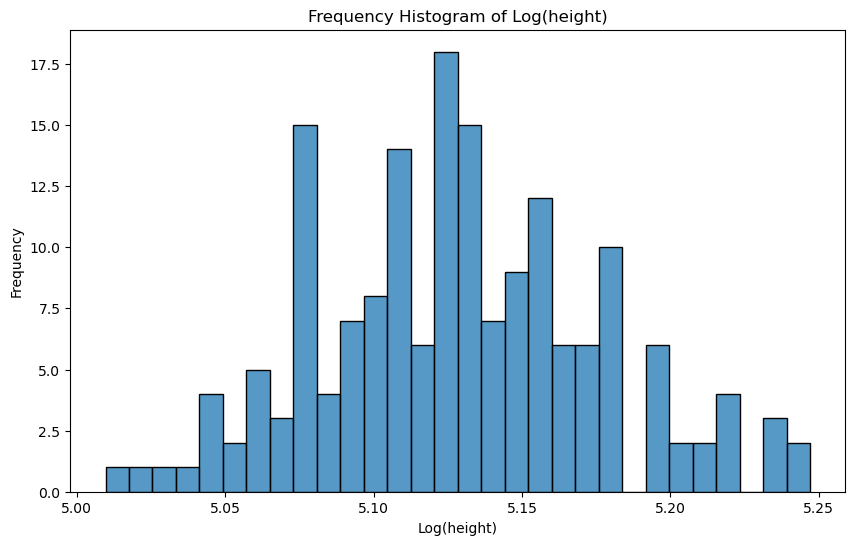

In [57]:
# similar skewness was observed for weight and height in participants
df_p['log_weight'] = np.log(df_p['weight'])
df_p['log_height'] = np.log(df_p['height'])

# weight transformation plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_p, x='log_weight', bins=30)
plt.title('Frequency Histogram of Log(weight)')
plt.xlabel('Log(weight)')
plt.ylabel('Frequency')
plt.show()

# height transformation plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_p, x='log_height', bins=30)
plt.title('Frequency Histogram of Log(height)')
plt.xlabel('Log(height)')
plt.ylabel('Frequency')
plt.show()


Comment: this transformed distribution is more normally distributed (less skewed).

## 6. New Feature Creation

For the new feature, we want to reduce the measurement for body condition, so we create BMI from weight and height.

In [58]:
# adding BMI column
df_p['BMI'] = df_p['weight'] / ((df_p['height'] / 100) ** 2)
df_p[['height', 'weight', 'BMI']].head()


,height,weight,BMI
0,170.18,96.162,33.203698
1,174.00,77.300,25.531774
2,178.00,92.000,29.036738
3,169.00,60.000,21.007668
4,158.00,68.500,27.439513


c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


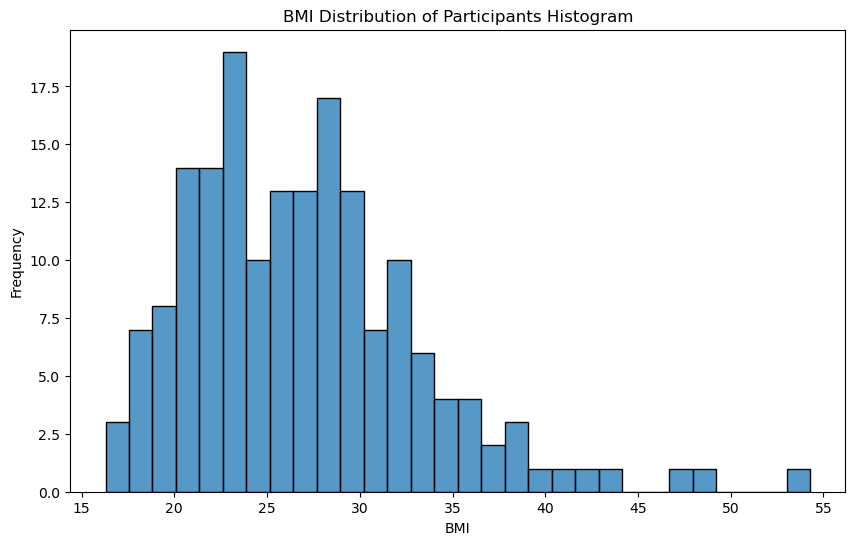

In [59]:
# BMI plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_p, x='BMI', bins=30)
plt.title('BMI Distribution of Participants Histogram')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

c:\Users\Harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


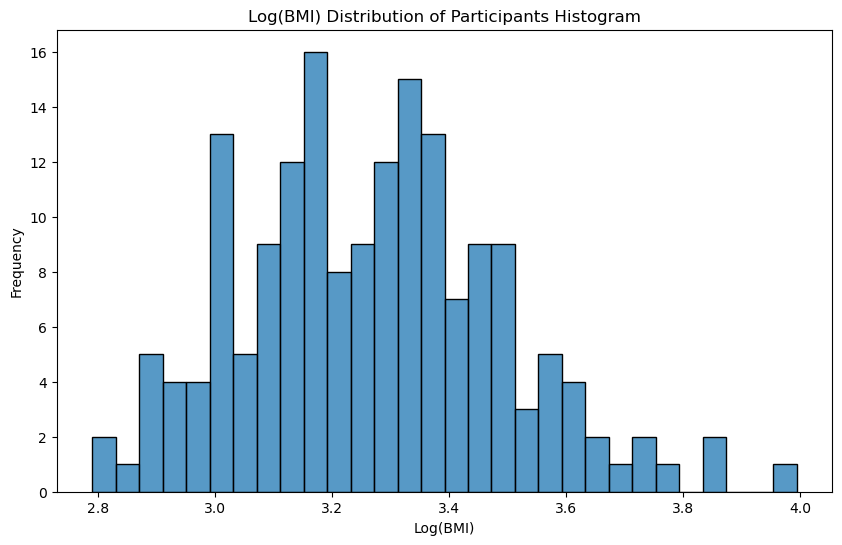

In [60]:
df_p['log_BMI'] = np.log(df_p['BMI'])

# BMI transformation plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_p, x='log_BMI', bins=30)
plt.title('Log(BMI) Distribution of Participants Histogram')
plt.xlabel('Log(BMI)')
plt.ylabel('Frequency')
plt.show()

New Feature comment: Used height and weight to create a new BMI column. Similar skewing to height and weight was observed in BMI so we used the log transformaiton and achieved a more normal distribution.

## 7. Dimensionality Reduction

In [61]:
print(df_p.shape)
print(df_p.head())
print(df_bp.shape)
print(df_bp.head())
print(df_hr.shape)
print(df_hr.head())
print(df_hrv.shape)
print(df_hrv.head())

(174, 9)
    user_code gender age_range  height  weight  log_weight  log_height  \
0  007b8190cf      m     25-34  170.18  96.162    4.566034    5.136857   
1  013f6d3e5b      f     18-24  174.00  77.300    4.347694    5.159055   
2  01bad5a519      m     45-54  178.00  92.000    4.521789    5.181784   
3  0210b20eea      f     25-34  169.00  60.000    4.094345    5.129899   
4  024719e7da      f     45-54  158.00  68.500    4.226834    5.062595   

         BMI   log_BMI  
0  33.203698  3.502661  
1  25.531774  3.239924  
2  29.036738  3.368562  
3  21.007668  3.044888  
4  27.439513  3.311984  
(160, 8)
    user_code measurement_date  diastolic    systolic  \
1  01bad5a519       2020-04-30  96.666667  143.333333   
2  01bad5a519       2020-05-01  80.000000  126.000000   
3  01bad5a519       2020-05-03  77.333333  114.666667   
4  01bad5a519       2020-05-04  85.600000  123.600000   
5  01bad5a519       2020-05-06  89.333333  132.000000   

   functional_changes_index  circulatory_eff

In [62]:
# sampling data to reduce memory usage
sampled_df_bp = df_bp.sample(n=100, random_state=0)
sampled_df_hr = df_hr.sample(n=100, random_state=0)
sampled_df_hrv = df_hrv.sample(n=100, random_state=0)
sampled_df_p = df_p.sample(n=100, random_state=0)

# merging data
merged_df = pd.merge(sampled_df_p, sampled_df_bp, on='user_code', how='inner')
merged_df = pd.merge(merged_df, sampled_df_hr, on='user_code', how='inner')
merged_df_ = pd.merge(merged_df, sampled_df_hrv, on='user_code', how='inner')
merged_df.head(10)

,user_code,gender,age_range,height,weight,log_weight,log_height,BMI,log_BMI,measurement_date,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index,datetime,heart_rate,is_resting,log_heart_rate
0,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-05-08,78.000000,107.0,2.61,2320.0,3.0,85.60,2020-05-24 04:38:00,65,0,4.174387
1,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-05-08,78.000000,107.0,2.61,2320.0,3.0,85.60,2020-05-17 00:59:00,68,0,4.219508
2,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-05-08,78.000000,107.0,2.61,2320.0,3.0,85.60,2020-05-09 15:00:00,68,1,4.219508
3,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-05-08,78.000000,107.0,2.61,2320.0,3.0,85.60,2020-04-29 06:16:00,79,0,4.369448
4,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-04-28,85.200000,119.6,3.12,2550.0,-15.0,108.80,2020-05-24 04:38:00,65,0,4.174387
5,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-04-28,85.200000,119.6,3.12,2550.0,-15.0,108.80,2020-05-17 00:59:00,68,0,4.219508
6,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-04-28,85.200000,119.6,3.12,2550.0,-15.0,108.80,2020-05-09 15:00:00,68,1,4.219508
7,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-04-28,85.200000,119.6,3.12,2550.0,-15.0,108.80,2020-04-29 06:16:00,79,0,4.369448
8,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-05-11,83.333333,115.0,2.91,3066.0,-19.0,94.17,2020-05-24 04:38:00,65,0,4.174387
9,fde84801d8,f,45-54,168.0,79.5,4.375757,5.123964,28.167517,3.338169,2020-05-11,83.333333,115.0,2.91,3066.0,-19.0,94.17,2020-05-17 00:59:00,68,0,4.219508


In [63]:

columns = ['log_height', 'log_weight', 'log_BMI', 'diastolic', 'systolic', 'heart_rate']

# standardizing data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[columns])

# applying PCA with 2 principal components for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
loadings = pca.components_
loading_df = pd.DataFrame(loadings.T, columns=['PCA1', 'PCA2'], index=columns)

print(loading_df)


                PCA1      PCA2
log_height -0.478893 -0.187505
log_weight -0.478893 -0.187505
log_BMI    -0.478893 -0.187505
diastolic  -0.373006  0.509685
systolic   -0.207320  0.765596
heart_rate  0.360372  0.220477


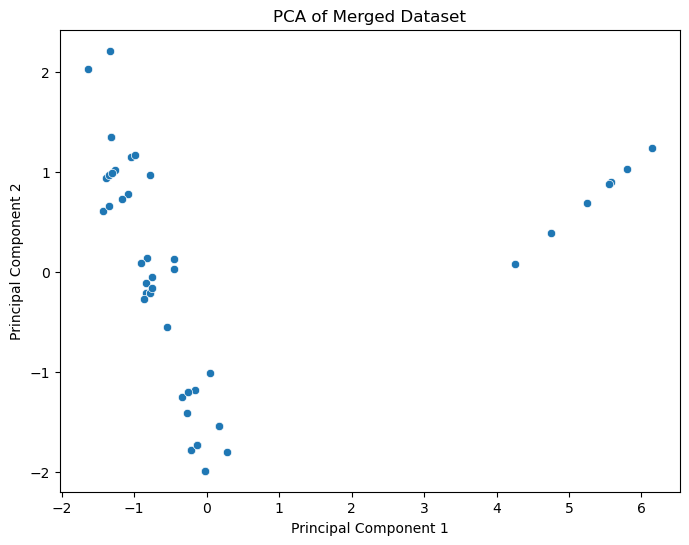

PC1 explains about 67.2% of the variance
PC2 explains about 21.6% of the variance


In [64]:
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
sampled_pca_df = pca_df.sample(n=50, random_state=0)

# scatterplot of PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=sampled_pca_df)
plt.title('PCA of Merged Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
explained_variance = pca.explained_variance_ratio_
print(f"PC1 explains about {round(explained_variance[0]*100, 1)}% of the variance")
print(f"PC2 explains about {round(explained_variance[1]*100, 1)}% of the variance")

#### Dimensionality Reduction Interpretation: 

PCA was chosen for dimensionality reduction to simplify the dataset while retaining as much variance as possible. Using PCA on the numerically correlated data allowed us to reduce the data to 2 principal components explaining 88.8% of the total variance. Each feature was standardized to ensure equal contribution. The resulting scatter plot reveals potential groupings in the dataset, which may warrant further investigation in future analyses.

## 8. Data Quality Discussion

Data profiling was done to understand the structure, distribution, and key statistical measures for the different datasets we used in this report. This includes blood pressure, heart rate, HRV measurements, and participant details. The datasets were sampled for analysis to maintain efficiency, with a random sampling method applied to ensure the data remains representative of the larger population.

Missing data was identified across the datasets, however there was hardly any missing data in the specific features we were interested in. Therefore, cleaning the data for use was simple. 

We deleted unrealistic outliars for heart rate, height, and weight. 

Ensuring consistency across the different datasets was essential, particularly when merging data sources. We primarily focused on ensuring the datetime and measurement formats were consistent. Merging the data on the user_code ensured data consistency as well.

Data integrity was maintained throughout the analysis by ensuring that no data was inadvertently lost during transformations or merging processes including merging validation and duplicate removal. 

The data for this analysis originated from publicly available datasets provided by Welltory and each dataset was sourced from health monitoring tools. The data was combined using the user_code field as the unique identifier. The lineage of the data was tracked throughout analysis to ensure transparency and reproducibility of results.